##Classification of flowers images using model Squeezenet on Cloud TPUs on Tensorflow.**bold text**


We need to access personal GCS bucket 
gs://nikhil-sanghi-tpu, authenticating this 

In [29]:
from google.colab import auth
auth.authenticate_user()

In [30]:
# Importing the required libraries
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from datetime import datetime

print("Tensorflow version " + tf.__version__)

AUTOTUNE = tf.data.AUTOTUNE

Tensorflow version 2.7.0


In [32]:
# Initialising variable
GCS_PATTERN_JPG = 'gs://flowers-public/*/*.jpg'
GCS_OUTPUT_TFR = 'gs://nikhil-sanghi-tpu/tfrecords-jpeg-192x192-2/flowers'  
TARGET_SIZE = [192, 192]
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips'] 
SHARDS=16

In [33]:
# some Utils functions for later use
# loading the dataset in numpy format from feature records format
def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  for images, labels in dataset:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    break;

  return numpy_images, numpy_labels

# extracting the title and label
def title_from_label_and_target(label, correct_label):
  label = np.argmax(label, axis=-1)  
  correct_label = np.argmax(correct_label, axis=-1) 
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

# displaying one image from our dataset
def display_one_image(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

# displaying a matrix of 9 images
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[np.argmax(labels[i], axis=-1)]
    subplot = display_one_image(image, title, subplot)
    if i >= 8:
      break;
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

# displaying matrix of images with predictions 
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(predictions[i], labels[i])
    subplot = display_one_image(image, title, subplot, not correct)
    if i >= 8:
      break;          
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

# plotting curves
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')    
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

#decoding the jpeg and label from tf.records
def decode_jpeg_and_label(filename):
  bits = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(bits)
  label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  label = label.values[-2]
  return image, label

# augmenting the image to size them in a fixed dimension
def resize_and_crop_image(image, label):
  w = tf.shape(image)[0]
  h = tf.shape(image)[1]
  tw = TARGET_SIZE[1]
  th = TARGET_SIZE[0]
  resize_crit = (w * th) / (h * tw)
  image = tf.cond(resize_crit < 1,
                  lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                  lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                 )
  nw = tf.shape(image)[0]
  nh = tf.shape(image)[1]
  image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
  return image, label

# recompressing an image
def recompress_image(image, label):
  height = tf.shape(image)[0]
  width = tf.shape(image)[1]
  image = tf.cast(image, tf.uint8)
  image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  return image, label, height, width

In [34]:
# finding the jpeg files in our cloud storage
nb_images = len(tf.io.gfile.glob(GCS_PATTERN_JPG))
shard_size = math.ceil(1.0 * nb_images / SHARDS)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, SHARDS, shard_size))

# listing the files in the storage folder and putting seed also shuffles the images file 
filenames = tf.data.Dataset.list_files(GCS_PATTERN_JPG, seed=35155) 
# creating a dataset
dataset = filenames.map(decode_jpeg_and_label, num_parallel_calls=AUTOTUNE)

Pattern matches 3670 images which will be rewritten as 16 .tfrec files containing 230 images each.


In [35]:
#resiszing and croping the images
dataset = dataset.map(resize_and_crop_image, num_parallel_calls=AUTOTUNE)

In [36]:
# recompressing the images
dataset = dataset.map(recompress_image, num_parallel_calls=AUTOTUNE)
# creating shards of image dataset
dataset = dataset.batch(shard_size)  

In [37]:

def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): 
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def _float_feature(list_of_floats): 
  return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))
  

def to_tfrecord(tfrec_filewriter, img_bytes, label, height, width):  
  class_num = np.argmax(np.array(CLASSES)==label) 
  one_hot_class = np.eye(len(CLASSES))[class_num]     

  feature = {
      "image": _bytestring_feature([img_bytes]), 
      "class": _int_feature([class_num]),        
      
      
      "label":         _bytestring_feature([label]),          
      "size":          _int_feature([height, width]),         
      "one_hot_class": _float_feature(one_hot_class.tolist()) 
  return tf.train.Example(features=tf.train.Features(feature=feature))
  
print("Writing TFRecords")
for shard, (image, label, height, width) in enumerate(dataset):
  
  shard_size = image.numpy().shape[0]
  
  filename = GCS_OUTPUT_TFR + "{:02d}-{}.tfrec".format(shard, shard_size)
  
  with tf.io.TFRecordWriter(filename) as out_file:
    for i in range(shard_size):
      example = to_tfrecord(out_file,
                            image.numpy()[i], 
                            label.numpy()[i],
                            height.numpy()[i],
                            width.numpy()[i])
      out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))

Writing TFRecords
Wrote file gs://nikhil-sanghi-tpu/tfrecords-jpeg-192x192-2/flowers00-230.tfrec containing 230 records
Wrote file gs://nikhil-sanghi-tpu/tfrecords-jpeg-192x192-2/flowers01-230.tfrec containing 230 records
Wrote file gs://nikhil-sanghi-tpu/tfrecords-jpeg-192x192-2/flowers02-230.tfrec containing 230 records
Wrote file gs://nikhil-sanghi-tpu/tfrecords-jpeg-192x192-2/flowers03-230.tfrec containing 230 records
Wrote file gs://nikhil-sanghi-tpu/tfrecords-jpeg-192x192-2/flowers04-230.tfrec containing 230 records
Wrote file gs://nikhil-sanghi-tpu/tfrecords-jpeg-192x192-2/flowers05-230.tfrec containing 230 records
Wrote file gs://nikhil-sanghi-tpu/tfrecords-jpeg-192x192-2/flowers06-230.tfrec containing 230 records
Wrote file gs://nikhil-sanghi-tpu/tfrecords-jpeg-192x192-2/flowers07-230.tfrec containing 230 records
Wrote file gs://nikhil-sanghi-tpu/tfrecords-jpeg-192x192-2/flowers08-230.tfrec containing 230 records
Wrote file gs://nikhil-sanghi-tpu/tfrecords-jpeg-192x192-2/flowe

In [38]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  
        "class": tf.io.FixedLenFeature([], tf.int64),   
        
        
        "label":         tf.io.FixedLenFeature([], tf.string),  
        "size":          tf.io.FixedLenFeature([2], tf.int64),  
        "one_hot_class": tf.io.VarLenFeature(tf.float32)        
    }
    
    example = tf.io.parse_single_example(example, features)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    
    class_num = example['class']
    
    label  = example['label']
    height = example['size'][0]
    width  = example['size'][1]
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    return image, class_num, label, height, width, one_hot_class
    


option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

filenames = tf.io.gfile.glob(GCS_OUTPUT_TFR + "*.tfrec")
dataset4 = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
dataset4 = dataset4.with_options(option_no_order)
dataset4 = dataset4.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
dataset4 = dataset4.shuffle(300)

In [39]:
for image, class_num, label, height, width, one_hot_class in dataset4.take(300):
    print("Image shape {}, {}x{} px, class={} ({:>10}, {})".format(image.numpy().shape, width, height, class_num, label.numpy().decode('utf8'), one_hot_class))

Image shape (192, 192, 3), 192x192 px, class=0 (     daisy, [1. 0. 0. 0. 0.])
Image shape (192, 192, 3), 192x192 px, class=4 (    tulips, [0. 0. 0. 0. 1.])
Image shape (192, 192, 3), 192x192 px, class=1 ( dandelion, [0. 1. 0. 0. 0.])
Image shape (192, 192, 3), 192x192 px, class=0 (     daisy, [1. 0. 0. 0. 0.])
Image shape (192, 192, 3), 192x192 px, class=2 (     roses, [0. 0. 1. 0. 0.])
Image shape (192, 192, 3), 192x192 px, class=4 (    tulips, [0. 0. 0. 0. 1.])
Image shape (192, 192, 3), 192x192 px, class=4 (    tulips, [0. 0. 0. 0. 1.])
Image shape (192, 192, 3), 192x192 px, class=4 (    tulips, [0. 0. 0. 0. 1.])
Image shape (192, 192, 3), 192x192 px, class=3 (sunflowers, [0. 0. 0. 1. 0.])
Image shape (192, 192, 3), 192x192 px, class=1 ( dandelion, [0. 1. 0. 0. 0.])
Image shape (192, 192, 3), 192x192 px, class=2 (     roses, [0. 0. 1. 0. 0.])
Image shape (192, 192, 3), 192x192 px, class=1 ( dandelion, [0. 1. 0. 0. 0.])
Image shape (192, 192, 3), 192x192 px, class=0 (     daisy, [1. 

In [40]:

try: 
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() 
  strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: 
  strategy = tf.distribute.MirroredStrategy() 
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.14.110.18:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.14.110.18:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


In [41]:
GCS_PATTERN = 'gs://nikhil-sanghi-tpu/tfrecords-jpeg-192x192-2/*.tfrec'
IMAGE_SIZE = [192, 192]

if tpu:
  BATCH_SIZE = 16*strategy.num_replicas_in_sync  
else:
  BATCH_SIZE = 32  


VALIDATION_SPLIT = 0.19
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)

# test and train splitting of data
filenames = tf.io.gfile.glob(GCS_PATTERN)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 128, there will be 23 batches per training epoch and 5 batch(es) per validation run.


In [42]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "class": tf.io.FixedLenFeature([], tf.int64),  
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) 
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class

def load_dataset(filenames):
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
  return dataset

In [43]:
def data_augment(image, one_hot_class):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, one_hot_class

def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() 
  if train:
    
    dataset = dataset.repeat()
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(2000)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTOTUNE) 
  
  return dataset
  
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)

some_flowers, some_labels = dataset_to_numpy_util(load_dataset(validation_filenames), 160)

In [44]:
with strategy.scope(): 
  
  bnmomemtum=0.9
  def fire(x, squeeze, expand):
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
    return tf.keras.layers.concatenate([y1, y3])

  def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

  x = tf.keras.layers.Input(shape=[*IMAGE_SIZE, 3]) 

  y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
  y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(48, 96)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(64, 128)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(48, 96)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.GlobalAveragePooling2D()(y)
  y = tf.keras.layers.Dense(5, activation='softmax')(y)

  model = tf.keras.Model(x, y)

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'],)

  model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 192, 192, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 192, 192, 32  128        ['conv2d_16[0][0]']              
 ormalization)                  )                                                           

Learning rate per epoch:


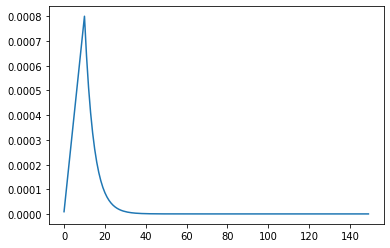

In [45]:
EPOCHS = 150
start_lr = 0.00001
min_lr = 0.000001
max_lr = 0.00010 * strategy.num_replicas_in_sync
rampup_epochs = 10
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [46]:
history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    callbacks=[lr_callback]
          )



Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/150
23/23 [==============================] - 30s 490ms/step - loss: 1.6208 - accuracy: 0.2398 - val_loss: 1.8865 - val_accuracy: 0.2478 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler setting learning rate to 8.9e-05.
Epoch 2/150
23/23 [==============================] - 4s 180ms/step - loss: 1.4604 - accuracy: 0.3665 - val_loss: 1.4595 - val_accuracy: 0.3507 - lr: 8.9000e-05

Epoch 00003: LearningRateScheduler setting learning rate to 0.000168.
Epoch 3/150
23/23 [==============================] - 4s 177ms/step - loss: 1.2841 - accuracy: 0.4854 - val_loss: 1.1844 - val_accuracy: 0.5116 - lr: 1.6800e-04

Epoch 00004: LearningRateScheduler setting learning rate to 0.000247.
Epoch 4/150
23/23 [==============================] - 4s 176ms/step - loss: 1.1887 - accuracy: 0.5425 - val_loss: 1.1089 - val_accuracy: 0.5493 - lr: 2.4700e-04

Epoch 00005: LearningRateScheduler setting learning rate to 0.000326.
Epoch 5/

In [47]:
final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

FINAL ACCURACY MEAN-5:  0.7530434966087342


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


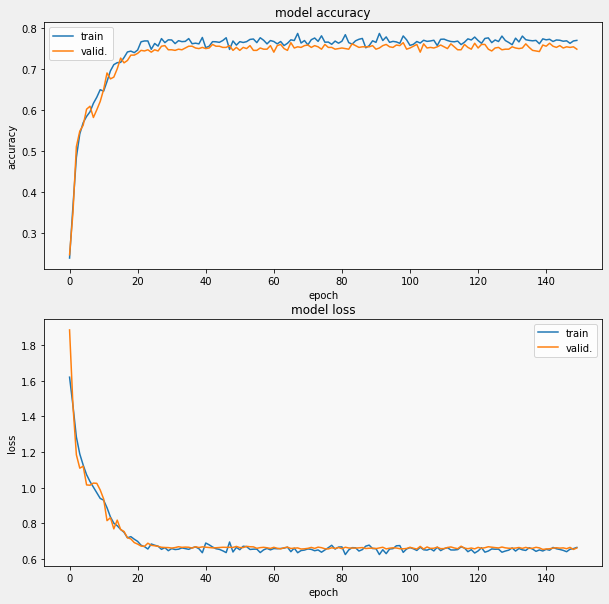

In [48]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [49]:
permutation = np.random.permutation(160)
some_flowers, some_labels = (some_flowers[permutation], some_labels[permutation])

predictions = model.predict(some_flowers, batch_size=16)
evaluations = model.evaluate(some_flowers, some_labels, batch_size=16)
  
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
print('[val_loss, val_acc]', evaluations)

10/10 [==============================] - 4s 20ms/step - loss: 0.6299 - accuracy: 0.7438
['tulips', 'dandelion', 'daisy', 'daisy', 'roses', 'tulips', 'daisy', 'roses', 'daisy', 'dandelion', 'tulips', 'daisy', 'sunflowers', 'tulips', 'dandelion', 'dandelion', 'tulips', 'sunflowers', 'tulips', 'dandelion', 'roses', 'roses', 'daisy', 'dandelion', 'tulips', 'dandelion', 'dandelion', 'tulips', 'daisy', 'dandelion', 'tulips', 'roses', 'tulips', 'dandelion', 'sunflowers', 'dandelion', 'dandelion', 'tulips', 'tulips', 'sunflowers', 'sunflowers', 'dandelion', 'daisy', 'dandelion', 'dandelion', 'roses', 'roses', 'daisy', 'roses', 'sunflowers', 'dandelion', 'sunflowers', 'tulips', 'roses', 'daisy', 'tulips', 'dandelion', 'roses', 'sunflowers', 'roses', 'daisy', 'sunflowers', 'daisy', 'dandelion', 'daisy', 'sunflowers', 'tulips', 'roses', 'dandelion', 'roses', 'sunflowers', 'sunflowers', 'sunflowers', 'tulips', 'dandelion', 'roses', 'tulips', 'dandelion', 'daisy', 'dandelion', 'sunflowers', 'daisy'